**Deep Learning 2023/24 - Final Project**
===============

Prediction of Stock Prices
---------------

## Team:
- Lukas Fabio Weigmann
- Andre Datchev
- Hannes Pohnke

-----------------------------------

In [477]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE


## **1. Introduction**
----------------------------------

In this project we will use LSTM Neural Networks to predict the future development of stock prices (the adjusted close in our case) based solely on historical prices of that exact stock (or index). We'll use two approaches: a straightforward, rather naive method to predict actual stock prices in the future and a more comprehensive approach categorizing stock price development into discrete groups (1) / predicting the percental development for a given time frame (2). By analyzing the historical data, we aim to uncover insights into the predictability of stock price movements and the potential of pattern recognition in financial forecasting. For no particular reason, we chose to use data from the Dow Jones index and its components.

## **2. Acquiring data**

----------------------------------

We will use yfinance to load the price histories.  

/Users/lukasweigmann/miniconda3/envs/FinancialForecasting/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


                    Open          High           Low         Close  \
Date                                                                 
2014-02-12  15993.040039  16036.559570  15928.750000  15963.940430   
2014-02-13  15946.990234  16039.370117  15863.250000  16027.589844   
2014-02-14  16018.080078  16175.549805  15985.389648  16154.389648   
2014-02-18  16153.969727  16167.330078  16107.040039  16130.400391   
2014-02-19  16126.230469  16225.719727  16031.660156  16040.559570   

               Adj Close    Volume  
Date                                
2014-02-12  15963.940430  77310000  
2014-02-13  16027.589844  99470000  
2014-02-14  16154.389648  84060000  
2014-02-18  16130.400391  91250000  
2014-02-19  16040.559570  80560000   
 (2517, 6) 

               Adj Close
Date                    
2014-02-12  15963.940430
2014-02-13  16027.589844
2014-02-14  16154.389648
2014-02-18  16130.400391
2014-02-19  16040.559570


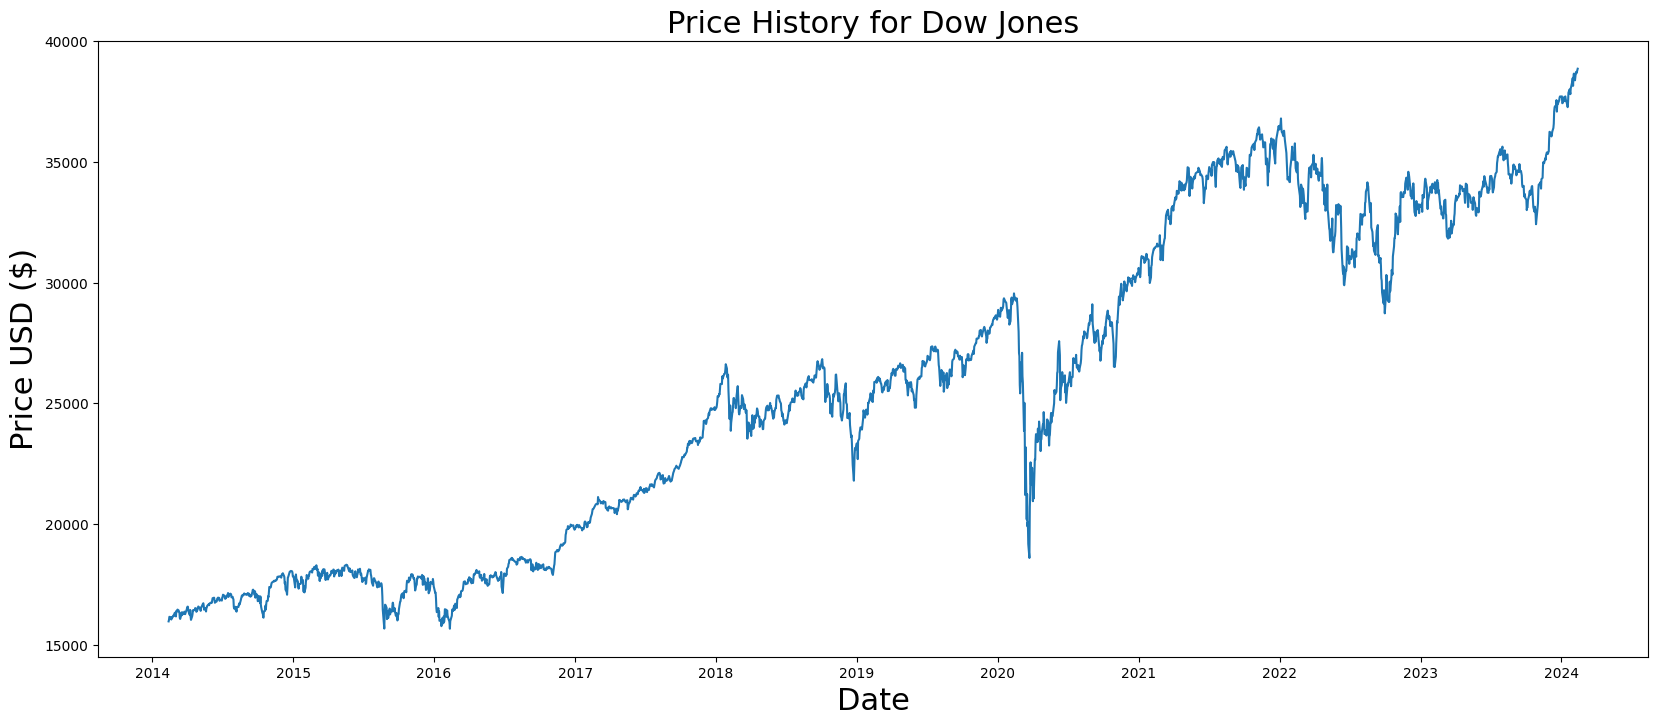

In [554]:
yf.pdr_override()
pd.set_option('display.max_rows', None)

#timeframe we want to load the data from in years
timeframe = 10

#setting end and start date 
end = datetime.now()
    #end = datetime(end .year - 1, end.month, end.day)
start = datetime(end.year - timeframe, end.month, end.day)

#how the downloaded dataframe looks
dow = pdr.get_data_yahoo("^DJI", start, end)
print(dow.head(), "\n", dow.shape, "\n")

#extracting the price history
dow_history = dow.filter(["Adj Close"])
print(dow_history.head())

#visulazing
def plot_history(history, index):
    plt.figure(figsize=(20,8))
    plt.title('Price History for ' + index, fontsize=22)
    plt.plot(history)
    plt.xlabel('Date', fontsize=22)
    plt.ylabel('Price USD ($)', fontsize=22)

    plt.show()
    
plot_history(dow_history, "Dow Jones")


## **3. The Naive Approach**
---------------------------------

At first we will choose a naive approach, similiar to the article that was linked in the project task.   
As we will see, in this approach we just predict the price of the following day.

Link to the article: https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f

### 3.1 Data Preprocessing

In [555]:
#Feature Scaling
dataset = dow_history.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)
print(scaled_dataset[:5])

[[0.01309376]
 [0.0158374 ]
 [0.02130317]
 [0.0202691 ]
 [0.01639647]]


In [557]:
#lookback window for prediction:
lag = 60

#train test split:
ratio = 0.8

train_data_len = int(np.ceil( len(dataset) * ratio ))

train_data, test_data = scaled_dataset[:train_data_len, :], scaled_dataset[train_data_len - lag:]

print(len(dataset), "=", len(train_data), "+", len(test_data), "+", lag)

2517 = 2014 + 563 + 60


In [558]:
# Data transformation: We will create datasamples with a corresponding label from our linear history. 
# Each sample will be <lag> consecutive values and the label y will be the price for the day after that time series.

def create_samples(sequential_data, lag=20):
    x, y = [], []
    
    for i in range(lag, len(sequential_data)):
        x.append(sequential_data[i-lag:i, 0])
        y.append(sequential_data[i, 0])
    return np.array(x), np.array(y)

train_X, train_Y = create_samples(train_data, lag)


test_X, test_Y = create_samples(test_data, lag)

### 3.2 Our Naive Model

In [559]:
#initializing model
model = Sequential()
model.add(LSTM(8, input_shape= (lag, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

2024-02-12 19:46:58.721084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-12 19:46:58.722843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-12 19:46:58.723691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [560]:
#training
model.fit(train_X, train_Y, batch_size=1, epochs=1)

2024-02-12 19:47:00.043420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-12 19:47:00.044675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-12 19:47:00.045355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1954/1954 [==============================] - 8s 4ms/step - loss: 0.0016


In [561]:
# making predictions
predictions = model.predict(test_X)

# scaling our predictions back to actual price values
predictions = scaler.inverse_transform(predictions)

#print(dataset[train_data_len:train_data_len + 5])
#print(predictions[:5])

16/16 [==============================] - 0s 1ms/step


2024-02-12 19:47:09.773058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-12 19:47:09.773901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-12 19:47:09.774342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

<class 'pandas.core.frame.DataFrame'>


/var/folders/nq/txffqhjx7fj21328vd8t3g_80000gn/T/ipykernel_54247/4224382542.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = preds


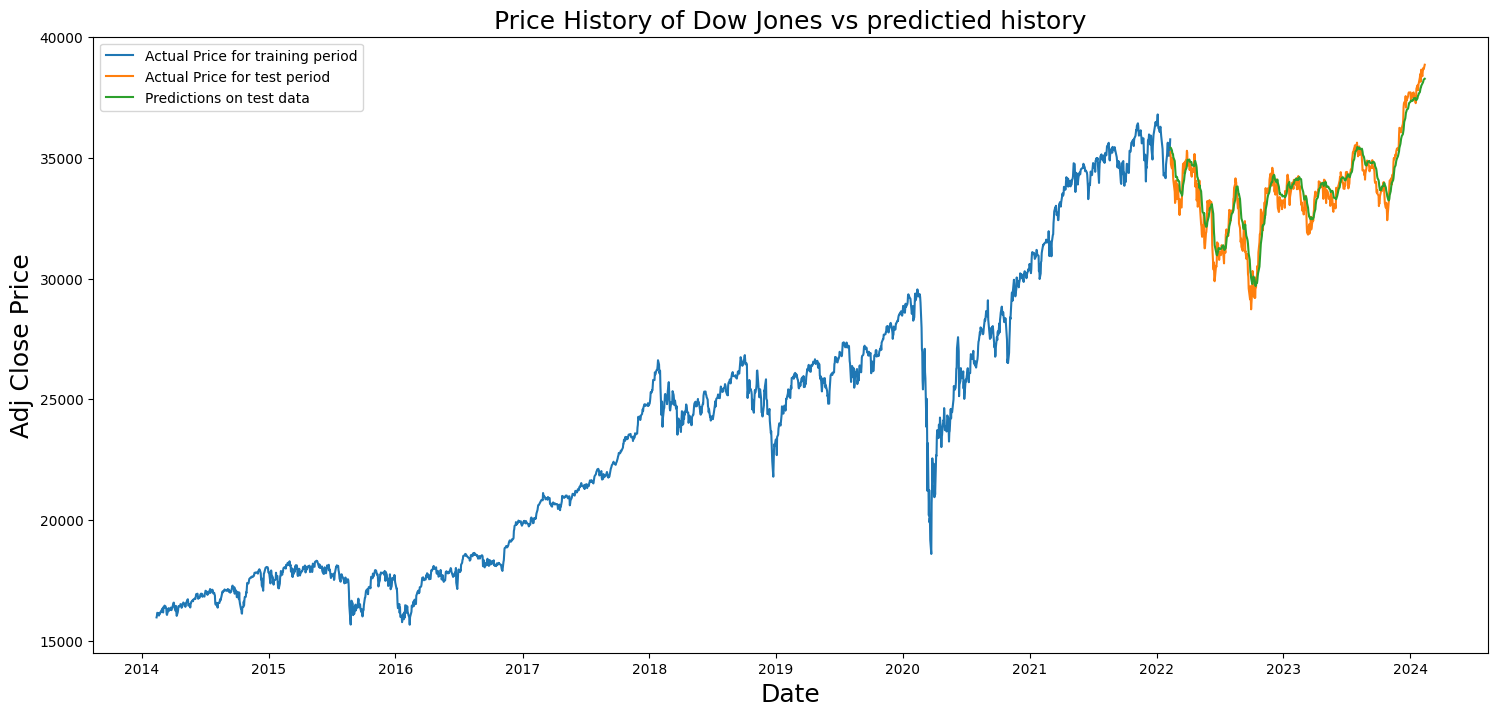

MSE: 1145201150.7461352


In [562]:
mse = mean_squared_error(predictions, test_Y)
rmse = np.sqrt(mse)

#visualize Results
def plot_results(stock, train, test, preds):
    test['predictions'] = preds
    
    plt.figure(figsize=(18,8))
    plt.plot(train)
    plt.plot(test)
    plt.title(f"Price History of {stock} vs predictied history", fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price', fontsize=18)
    plt.legend(['Actual Price for training period', 'Actual Price for test period', 'Predictions on test data'])
    
    plt.show()
    

print(type(dow_history))
train_history = dow_history[:train_data_len]
test_history = dow_history[train_data_len:]
plot_results("Dow Jones", train_history, test_history, predictions)

print(f"MSE: {mse}")

Our naive model is very simplistic, it consists of a single LSTM layer with 8 input neurons and got trained for just one epoch. Nevertheless, our performance looks increadibly well.  

That is because we effectivly only predict the value of the following day after an input series, but don't use our own predictions when predicting the next day after that.
What happens is, that every prediction is based on 60 (when the lag is 60) ground truth values. So everything this naive model does, is predicting a price, that is very close to the last couple values in the input series. To visualize that, we can see in the plot how the green line just mimics the orange line with a slight time delay. Exactly this approach has been chosen by multiple people, including the linked article and other public Kaggle notebooks.
In real life applications this model is useless though.

If we would use our own predictions as input for following predictions (i.e. predicting further into the future) the green plot would most likely look linear, predicting values close to the same last price over and over again. This can also be seen in the plot below.

1/1 [==============================] - 0s 13ms/step


/var/folders/nq/txffqhjx7fj21328vd8t3g_80000gn/T/ipykernel_54247/4224382542.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = preds


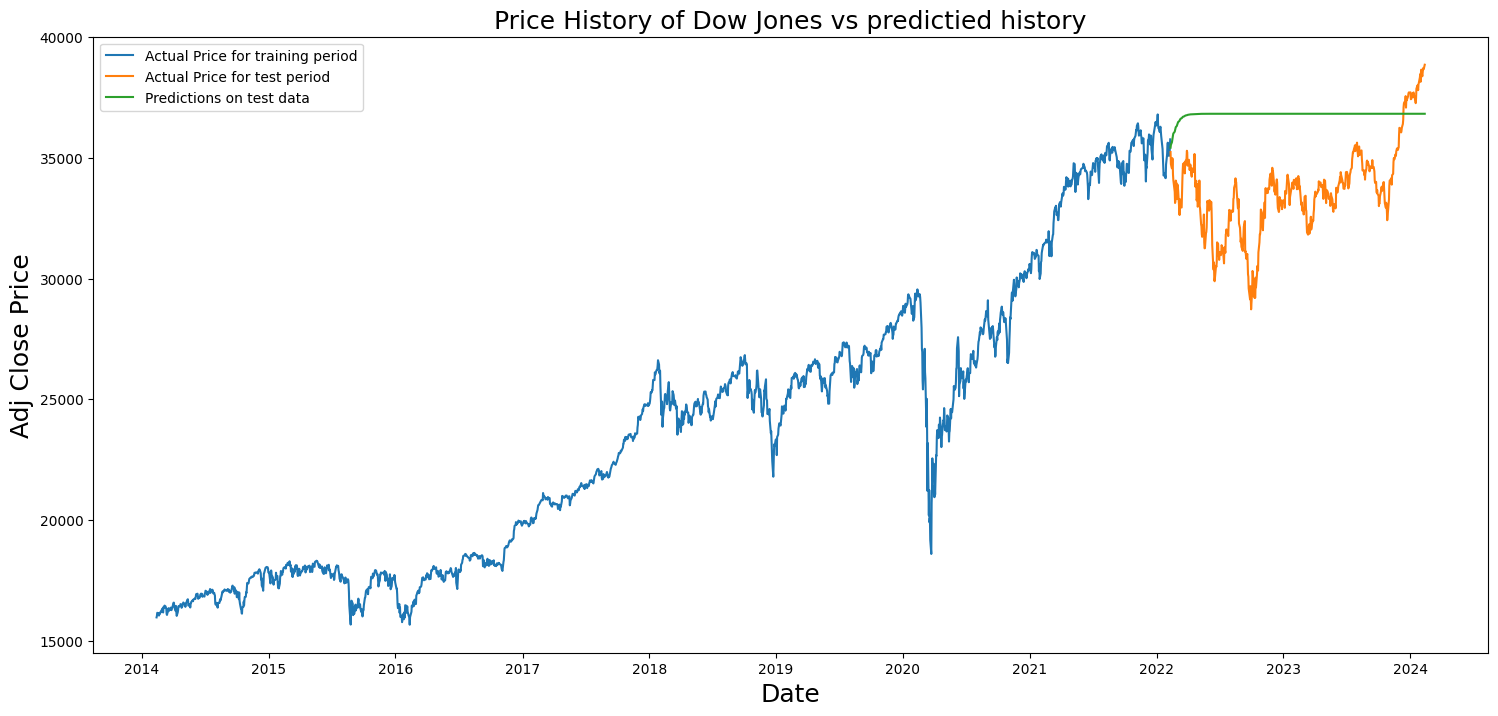

In [564]:
#longer predictions
data_sample = test_X[0:1]
#print(data_sample, "\n", test_X[0])
recursive_predictions = []
    
# Save the original stdout
for i in range(0, len(predictions)):
    pred = model.predict(data_sample)[0]
    recursive_predictions.append(pred)
    data_sample = np.roll(data_sample, -1)
    data_sample[-1] = pred
    
recursive_predictions = scaler.inverse_transform(recursive_predictions)
plot_results("Dow Jones", train_history, test_history, recursive_predictions)

## **4. Adjusting the Task**
---------------------------------

Since a prediction for the next day is not really useful, we want to do a prediction about the development of the index in a certain timeframe e.g. 7 days. Therefore we will do a classicification in 5 categories (1) and a direct prediction of the percental change (2). For the classification we compare the price of the current date with the price at a future point in time and categorize the increase/decrease. The idea is to get a category for a small increase, a big increase, stagnation, small decrease and big decrease. This way we want to obtain a more abstract tendency or trend, based on past data.
We consider this a more useful and robust approach since the stock price is also very dependent on daily events and in order to obtain more abstract trends the market needs a wider time frame.

First we will smooth the data in order to filter out short term trends

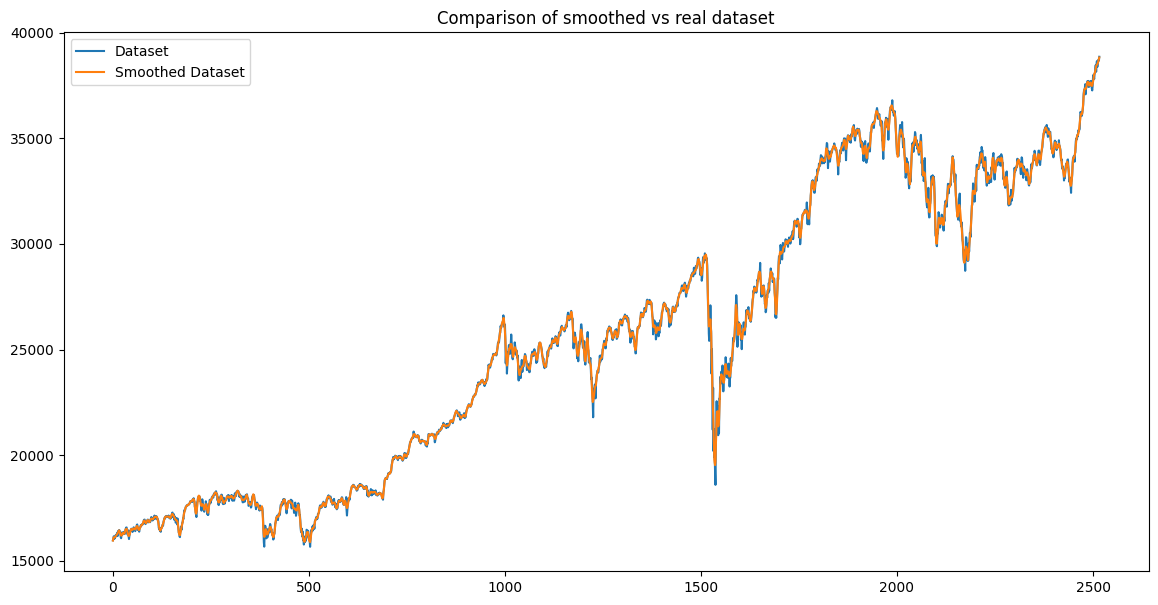

In [565]:
# Smoothing the curve with moving average

smoothed_dataset = savgol_filter(dataset[:,0], window_length=15, polyorder=5).reshape(-1,1)

plt.figure(figsize=(14,7))
plt.plot(dataset)
plt.plot(smoothed_dataset)
plt.title("Comparison of smoothed vs real dataset")
plt.legend(["Dataset","Smoothed Dataset"])


In [566]:
def getTrainingAndTestData(lag=60):
    ratio = 0.8

    train_data_len = int(np.ceil( len(dataset) * ratio ))

    train_data = smoothed_dataset[:train_data_len, :]
    test_data = smoothed_dataset[train_data_len - lag:]
    
    return train_data, test_data 


Now we will create the samples for the classification task (1) and the precental change prediction (2)

In [567]:
# We will create samples that use the past <lag> days and are labelled with the category label
# according to percental change in the next <predictionPeriod>
# In between the samples there is a shift of <shift> days in order to avoid too similar training samples

label_map = {0: 'below -10%', 1: '-10% to -3%',2: '-3% to 3%',3: '3% to 10%',4: 'above 10%'}

def create_samples(sequential_data, category_boundaries=[-10, -3, 3, 10], shift=15, lag=60, prediction_period=7):
    x, y = [], []
    
    for i in range(lag, len(sequential_data)-prediction_period, shift):
        x.append(sequential_data[i-lag:i, 0])
        percental_change = (sequential_data[i+prediction_period]/sequential_data[i]-1)*100
        for index, boundary in enumerate(category_boundaries):
            if percental_change <= boundary:
                y.append(index)
                break
        if percental_change > category_boundaries[3]:
            y.append(4)
    return np.array(x), np.array(y)

def create_samples_2(sequential_data, shift=3, lag=60, prediction_period=7):
    x, y = [], []
    
    for i in range(lag, len(sequential_data)-prediction_period, shift):
        x.append(sequential_data[i-lag:i, 0])
        percental_change = (sequential_data[i+prediction_period]/sequential_data[i]-1)
        y.append(percental_change)
    return np.array(x), np.array(y)

In [568]:
train_data, test_data = getTrainingAndTestData()

train_X, train_Y = create_samples(train_data)

test_X, test_Y = create_samples(test_data)

train_X.shape, train_Y.shape

((130, 60), (130,))

In [529]:
train_X_2, train_Y_2 = create_samples_2(train_data)

test_X_2, test_Y_2 = create_samples_2(test_data)

np.set_printoptions(suppress=True, precision=4)
print(train_Y_2)

print(train_X_2[0])
train_X_2.shape, train_Y_2.shape

[[-0.0091]
 [-0.0007]
 [ 0.0146]
 [ 0.0118]
 [ 0.0125]
 [ 0.0084]
 [-0.004 ]
 [ 0.0013]
 [ 0.0067]
 [-0.0011]
 [ 0.0045]
 [ 0.0085]
 [ 0.0025]
 [ 0.0038]
 [ 0.0075]
 [ 0.002 ]
 [-0.0126]
 [-0.03  ]
 [-0.0317]
 [-0.0084]
 [ 0.0158]
 [ 0.0234]
 [ 0.0255]
 [ 0.0166]
 [ 0.0048]
 [ 0.0003]
 [-0.0031]
 [-0.0008]
 [ 0.0084]
 [ 0.0076]
 [-0.0095]
 [-0.0146]
 [-0.0112]
 [-0.0156]
 [-0.0391]
 [-0.0313]
 [ 0.0151]
 [ 0.0392]
 [ 0.0424]
 [ 0.0417]
 [ 0.0284]
 [ 0.0153]
 [ 0.0063]
 [ 0.0069]
 [ 0.0101]
 [ 0.0072]
 [ 0.0066]
 [-0.0024]
 [-0.0342]
 [-0.0268]
 [ 0.0308]
 [ 0.0462]
 [ 0.0017]
 [-0.0268]
 [-0.0145]
 [-0.0071]
 [-0.0057]
 [ 0.0046]
 [-0.0061]
 [-0.0143]
 [ 0.0185]
 [ 0.0324]
 [ 0.016 ]
 [ 0.0121]
 [ 0.013 ]
 [ 0.01  ]
 [ 0.0001]
 [-0.021 ]
 [-0.0243]
 [ 0.0004]
 [ 0.0159]
 [ 0.0008]
 [-0.0192]
 [-0.0059]
 [ 0.0074]
 [ 0.0139]
 [ 0.0087]
 [-0.0019]
 [ 0.0013]
 [ 0.0034]
 [-0.0062]
 [-0.0022]
 [ 0.0091]
 [ 0.0156]
 [ 0.0139]
 [-0.003 ]
 [-0.0134]
 [-0.0137]
 [-0.0115]
 [-0.0077]
 [ 0.003 ]

((649, 60), (649, 1))

Now we print the distribution of the percental change values to get an overview for prediction 2.

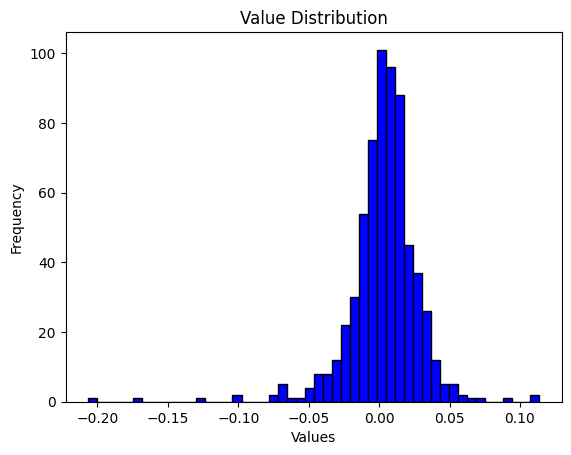

Bin Edges: [-100.           -1.46253646   -0.55438573    0.13383118    0.75257764
    1.35297754    2.33706679  100.        ]
Frequencies: [93 93 92 93 92 93 93]
Bin Labels (Medians): [-2.68479819 -0.90662892 -0.13479096  0.46115221  1.0844333   1.70671963
  3.18576837]
649 649


In [570]:
number_of_bins = 7

#Looking at the datadistribution for establishing the bins
mask = (train_Y_2 >= -10) & (train_Y_2 <= 10)
filtered_array = train_Y_2[mask]

plt.hist(filtered_array, bins=50, color='blue', edgecolor='black')
plt.title('Value Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

points_per_bin = len(filtered_array) // number_of_bins

# Calculate the bin edges to achieve approximately equal frequencies
bin_edges = np.array([np.percentile(filtered_array, i * 100 / number_of_bins) for i in range(number_of_bins + 1)])
bin_edges[0] = -1
bin_edges[-1] = 1

# Use numpy.histogram to compute frequencies
hist, _ = np.histogram(train_Y_2, bins=bin_edges)

# Calculate bin labels as the median of each bin
bin_labels = [np.median(train_Y_2[(train_Y_2 >= bin_edges[i]) & (train_Y_2 <= bin_edges[i+1])]) for i in range(number_of_bins)]
bin_labels = np.array(bin_labels)
print("Bin Edges:", bin_edges*100)
print("Frequencies:", hist)
print("Bin Labels (Medians):", bin_labels*100)

print(len(filtered_array), len(train_Y_2))#
np.set_printoptions(suppress=False, precision=8)  # Reset to default

For (1) we are doing a multiclass classification, which comes with a couple new challenges.  
At first we need categorical labels.

In [571]:
train_Y_cat = to_categorical(train_Y, num_classes=5)
test_Y_cat = to_categorical(test_Y, num_classes=5)

print(train_Y)
print("Variance: ", str(np.var(train_Y)))
print(train_Y_cat)

[2 2 2 2 2 2 2 1 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 3
 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2
 1 3 2 1 3 2 2 2 2 2 2 3 2 2 2 3 2 2 2 2 2 2 2 0 0 4 2 3 1 2 2 2 1 3 2 3 2
 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 1]
Variance:  0.245207100591716
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0.

Our data is imbalanced, as we will also see in the classification report later.  
To adress that we can weight the classes when training, to eliminate that bias.

In [572]:
# compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_Y), y=train_Y)

# convert to dictionary
class_weights_dict = dict(enumerate(class_weights))

Alternatively we can use Smote to artifically sample instances of less frequent classes.

In [574]:
#smote = SMOTE()

#train_X_resampled, train_Y_resampled = smote.fit_resample(train_X, train_Y_cat)


## **5. Our Models**
---------------------------------

#### 5.1 Classification model

In [576]:
#initializing model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (lag, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(5, activation='softmax')) # 5 ouput neurons for the 5 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-02-12 20:02:09.888901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-12 20:02:09.889559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-12 20:02:09.891618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [595]:
#training
#model.fit(train_X, train_Y_cat, batch_size=1, epochs=10) # without adressing imbalance performs best
model.fit(train_X, train_Y_cat, batch_size=3, epochs=10, class_weight=class_weights_dict) # weighted class version
#model.fit(train_X_resampled, train_Y_resampled, batch_size=1, epochs=10) # smote version

Epoch 1/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6311 - accuracy: 0.3077
Epoch 2/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6403 - accuracy: 0.0615
Epoch 3/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6422 - accuracy: 0.6846
Epoch 4/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6309 - accuracy: 0.8231
Epoch 5/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6333 - accuracy: 0.0846
Epoch 6/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6409 - accuracy: 0.0538
Epoch 7/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6283 - accuracy: 0.0692
Epoch 8/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6301 - accuracy: 0.0077
Epoch 9/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6381 - accuracy: 0.7231
Epoch 10/10
44/44 [==============================] - 1s 20ms/step - loss: 1.6313 - accuracy: 0.3385


#### 5.2 Percental change prediction model

In [577]:

#initializing model
model_2 = Sequential()

model_2.add(LSTM(128, return_sequences=True, input_shape= (60, 1)))
model_2.add(LSTM(64, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))

# Compile the model
model_2.compile(optimizer='adam', loss='mean_squared_error')

2024-02-12 20:02:56.630819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-12 20:02:56.631394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-12 20:02:56.632402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [580]:
model_2.fit(train_X_2, train_Y_2, batch_size=1, epochs=5, class_weight=class_weights_dict)

Epoch 1/5


2024-02-12 20:04:09.034892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-12 20:04:09.039323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-12 20:04:09.040080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

649/649 [==============================] - 8s 11ms/step - loss: 0.0112
Epoch 2/5
649/649 [==============================] - 7s 11ms/step - loss: 0.0095
Epoch 3/5
649/649 [==============================] - 7s 11ms/step - loss: 0.0090
Epoch 4/5
649/649 [==============================] - 7s 11ms/step - loss: 0.0089
Epoch 5/5
649/649 [==============================] - 7s 11ms/step - loss: 0.0088


## **6 Results and evaluation**

First we run the predictions for the classification task 1 and evaluate the results:

In [581]:
# making predictions
predictions = model.predict(test_X)
predicted_classes = np.argmax(predictions, axis=1)

# understand the predictions
print("Last 5 true Labels:")
print(test_Y[:5])
print([label_map[key] for key in test_Y[:5]])

print("\nLast 5 Predicted Labels:")
print(predicted_classes[:5])
print([label_map[key] for key in predicted_classes[:5]])

print("\nUnique predicted classes (should be [0,1,2,3,4]):")
print(np.unique(predicted_classes))

2024-02-12 20:04:55.885061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-12 20:04:55.886350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-12 20:04:55.886975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 6ms/step
Last 5 true Labels:
[1 2 2 1 2]
['-10% to -3%', '-3% to 3%', '-3% to 3%', '-10% to -3%', '-3% to 3%']

Last 5 Predicted Labels:
[2 2 2 2 2]
['-3% to 3%', '-3% to 3%', '-3% to 3%', '-3% to 3%', '-3% to 3%']

Unique predicted classes (should be [0,1,2,3,4]):
[2]


In [586]:
# Calculate cross-entropy loss
cross_entropy = model.evaluate(test_X, test_Y_cat, verbose=0)

# Calculate classification metrics
print(f"Cross-entropy Loss: {cross_entropy[0]}")
print(f"Accuracy: {cross_entropy[1]}")

# Print classification report
print(classification_report(test_Y, predicted_classes))

Cross-entropy Loss: 1.572157859802246
Accuracy: 0.7941176295280457
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.79      1.00      0.89        27
           3       0.00      0.00      0.00         2

    accuracy                           0.79        34
   macro avg       0.26      0.33      0.30        34
weighted avg       0.63      0.79      0.70        34



/Users/lukasweigmann/miniconda3/envs/FinancialForecasting/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lukasweigmann/miniconda3/envs/FinancialForecasting/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lukasweigmann/miniconda3/envs/FinancialForecasting/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

As we can see the model performs really bad since only category 2 is predicted. However we tried around a lot with different hyperparameters and were stuck with this problem.

Now for model 2:

In [587]:
# making predictions
predictions_2 = model_2.predict(test_X_2)

6/6 [==============================] - 0s 12ms/step


In [588]:
mse_2 = mean_squared_error(test_Y_2, predictions_2)
mse_2


0.000642541830091129

/var/folders/nq/txffqhjx7fj21328vd8t3g_80000gn/T/ipykernel_54247/1983238106.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_line.loc[day_7, 'Adj Close'] = price_day_7


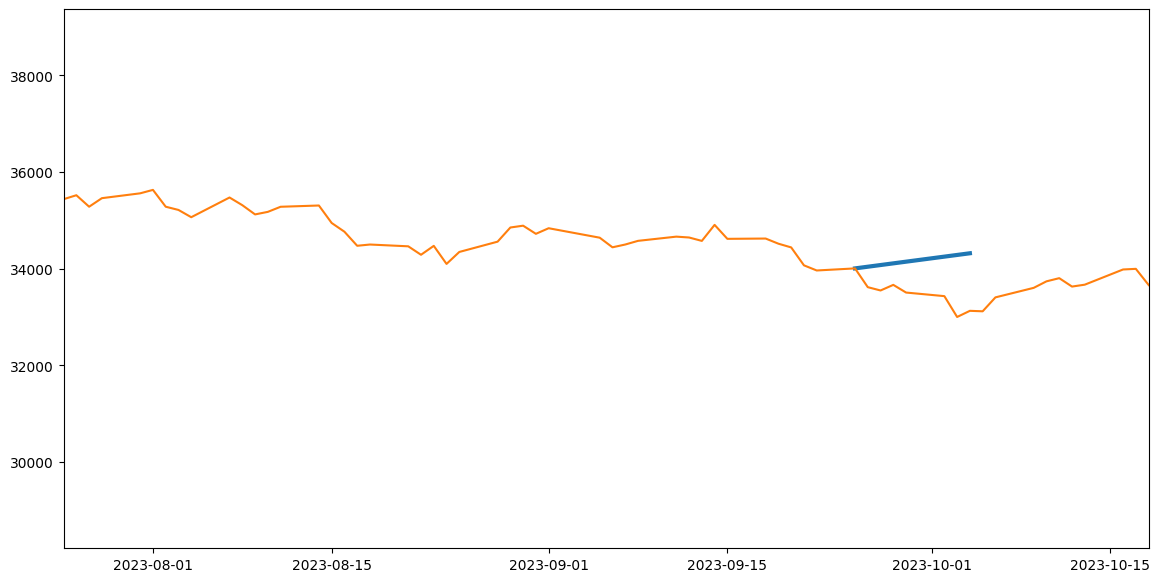

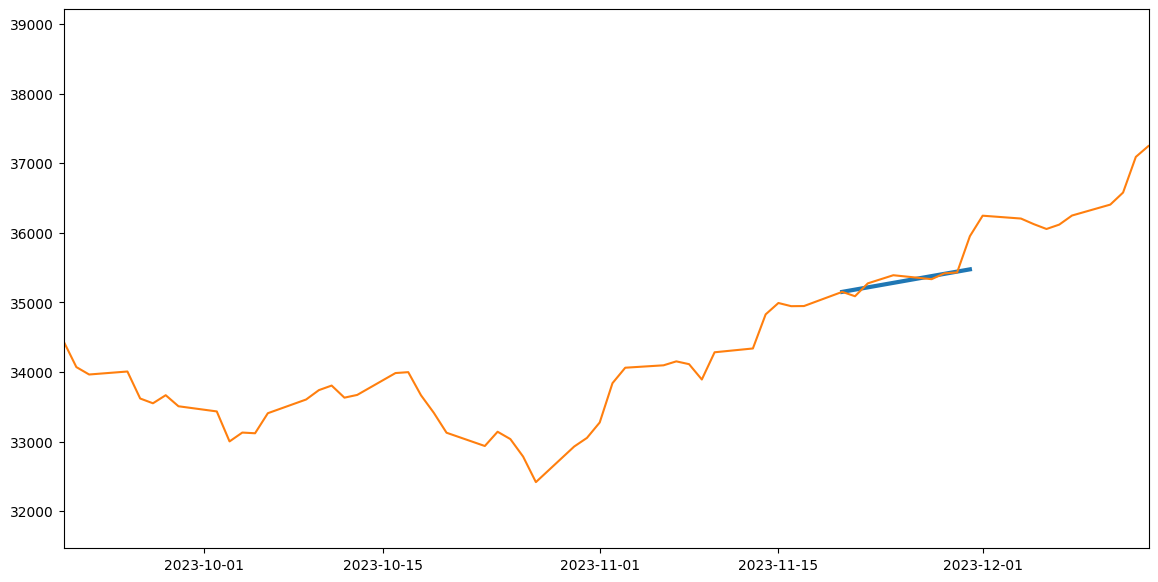

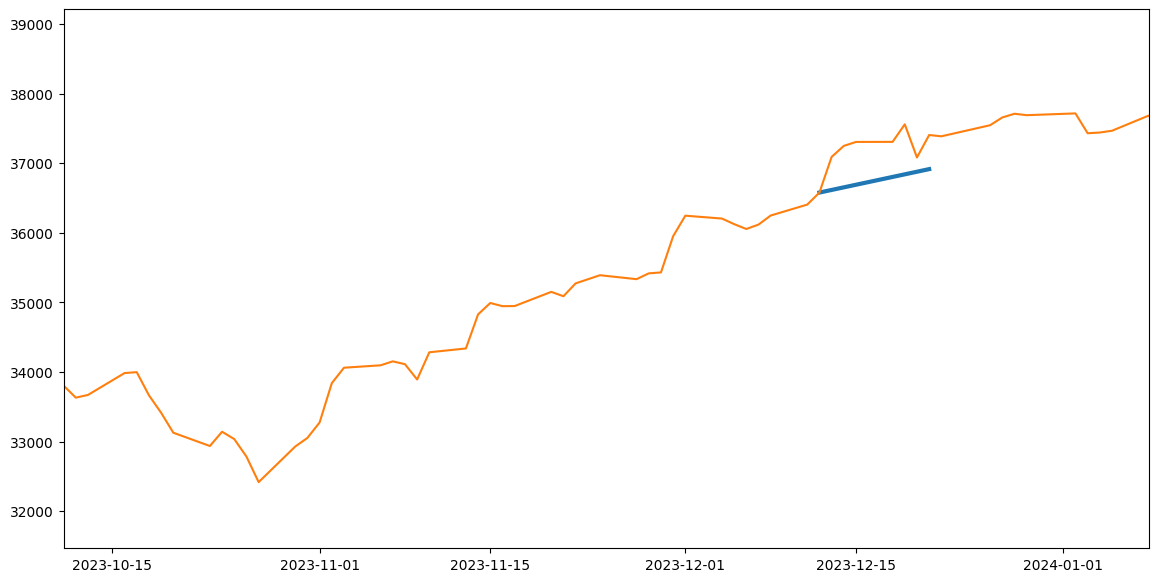

In [600]:
#Visualizing the latest prediction
for pred_to_plot in [-70, -50, -35]:
    train_period = dow_history[train_data_len+230+pred_to_plot:]

    day_0 = train_period.index[pred_to_plot-7]
    day_7 = train_period.index[pred_to_plot]
    price_day_0 = train_period.loc[day_0, 'Adj Close']
    price_day_7 = price_day_0 + price_day_0 * predictions_2[pred_to_plot]

    prediction_line = train_period.loc[train_period.index.isin([day_0,day_7])]
    prediction_line.loc[day_7, 'Adj Close'] = price_day_7

    plt.figure(figsize=(14,7))
    plt.plot(prediction_line, linewidth=3)
    plt.plot(train_period)
    plt.xlim(train_period.index[pred_to_plot-50], train_period.index[pred_to_plot+10])

    plt.show()

The results of our second prediction turned out better than for prediction 1. We can observe a quite low MSE and also in the graph we can see that our prediction makes sense.

## **7. Conclusion**
---------------------------------

For our classification we obtained no results that would be of value. Unfortunately also trying different hyperparameters didn't lead to better results.
The second one, however, turned out better than expected with good predictions. This was rather unexpected since this was the more precise and thus harder task whereas the classification was on a more abstract level.
The success of the second model suggests that future work can rework the classification task and further extend and improve the second model.

While pattern recognition in stock pricing seems to be a popular way to predict future prices, it's essential to recognize its limitations.  
Stock prices are profoundly influenced by various factors such as company performance, industry dynamics, and global events, which are often unpredictable.  
Thus, relying solely on price movement patterns doesn't provide a comprehensive or reliable basis for financial forecasting.  
Instead, a balanced approach incorporating the various "real life" influences on the price, should result in a higher prediction power.

Still we were surprised by the precision of predictions solely based on chart patterns.